In [1]:
import numpy as np
import pymc
import scipy as sp

ModuleNotFoundError: No module named 'pymc'

In [2]:
%pylab inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

Populating the interactive namespace from numpy and matplotlib


#The Order Dataset


| Experiment | Clicks | Orders | True Rate  | Empirical Rate |
|------------|--------|--------|------------|----------------|
|      A     | 1055   | 28     | 0.032      | 0.027          |
|      B     | 1057   | 45     | 0.041      | 0.043          |
|      C     | 1065   | 69     | 0.058      | 0.065          |
|      D     | 1039   | 58     | 0.047      | 0.056          |
|      E     | 1046   | 60     | 0.051      | 0.057          |

#Standard A/B Testing Model

In [3]:
values_A = np.hstack(([0]*(1055-28),[1]*28))
values_B = np.hstack(([0]*(1057-45),[1]*45))

In [4]:
p_A = pymc.Uniform('p_A', 0, 1)
p_B = pymc.Uniform('p_B', 0, 1)

@pymc.deterministic
def delta(p_A = p_A, p_B = p_B):
    return p_B - p_A

obs_A = pymc.Bernoulli('obs_A', p_A, value = values_A , observed = True)
obs_B = pymc.Bernoulli('obs_B', p_B, value = values_B , observed = True)
model = pymc.Model([p_A, p_B, delta, values_A, values_B])
mcmc = pymc.MCMC(model)

mcmc.sample(1000000, 500000)

 [-----------------100%-----------------] 1000000 of 1000000 complete in 67.2 sec

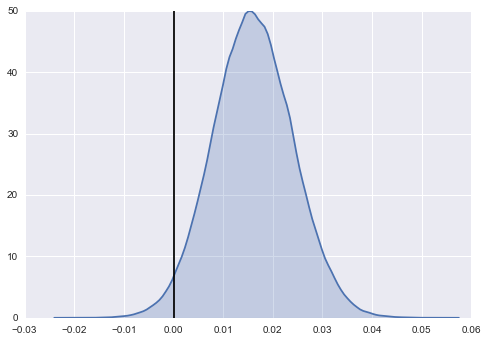

In [5]:
siteA_distribution = mcmc.trace("p_A")[:]
siteB_distribution = mcmc.trace("p_B")[:]
delta_distribution = mcmc.trace('delta')[:]

sns.kdeplot(delta_distribution, shade = True)
plt.axvline(0.00, color = 'black')
plt.savefig("results/2sites_diff.png", format = "PNG")

In [26]:
print "Probability that website A gets MORE sign-ups than website B: %0.3f" % (delta_distribution < 0).mean()
print "Probability that website A gets LESS sign-ups than website B: %0.3f" % (delta_distribution > 0).mean()

Probability that website A gets MORE sign-ups than website B: 0.022
Probability that website A gets LESS sign-ups than website B: 0.978


#Beta Distribution and Bayesian Priors

In [7]:
from scipy.stats import uniform,beta

In [8]:
support = np.linspace(0,1, 500)[1:-1]

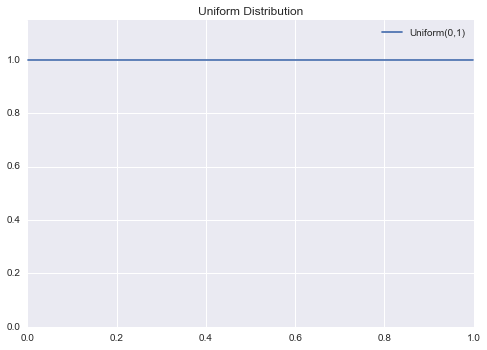

In [9]:
U_01 = uniform()
plt.plot(support, U_01.pdf(support), label = "Uniform(0,1)")
plt.ylim(0,1.15)
plt.legend()
plt.title("Uniform Distribution")
plt.savefig("results/Uniform.png", format="PNG")

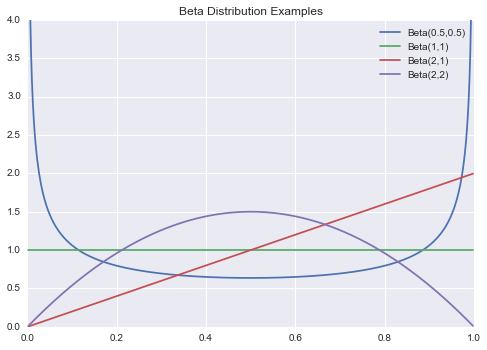

In [10]:
a_vals = [0.5, 1, 2, 2]
b_vals = [0.5, 1, 1, 2]
for a,b in zip(a_vals, b_vals):
    plt.plot(support, beta(a,b).pdf(support), label = "Beta(%s,%s)" %(a,b))
plt.legend()
plt.ylim(0,4)
plt.title("Beta Distribution Examples")
plt.savefig("results/Beta.png", format="PNG")

#Hierachical Models

In [12]:
@pymc.stochastic(dtype=np.float64)
def beta_priors(value=[1.0, 1.0]):
    a, b = value
    if a <= 0 or b <= 0:
        return -np.inf
    else:
        return np.log(np.power((a + b), -2.5))

a = beta_priors[0]
b = beta_priors[1]

#The hidden, true rate for each website.
true_rates = pymc.Beta('true_rates', a, b, size=5)

# This is what we observed
trials = np.array([1055, 1057, 1065, 1039, 1046])
successes = np.array([28, 45, 69, 58, 60])
observed_values = pymc.Binomial('observed_values', trials, true_rates, observed=True, value=successes)

model = pymc.Model([a, b, true_rates, observed_values])
mcmc = pymc.MCMC(model)

# Generate 1M samples, and throw out the first 500k
mcmc.sample(1000000, 500000)

 [-----------------100%-----------------] 1000000 of 1000000 complete in 90.9 sec

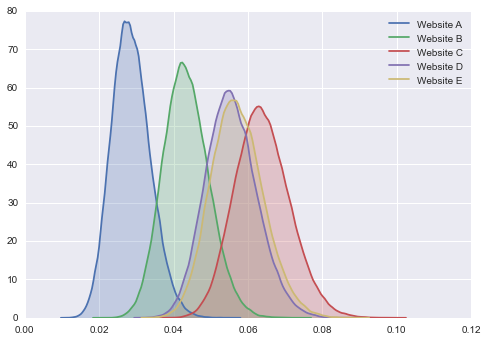

In [13]:
for i in range(5):
    sns.kdeplot(mcmc.trace('true_rates')[:][:,i], shade = True, label = "Website %s" % chr(65+i))
plt.savefig("results/five_hier.png", format = "PNG")

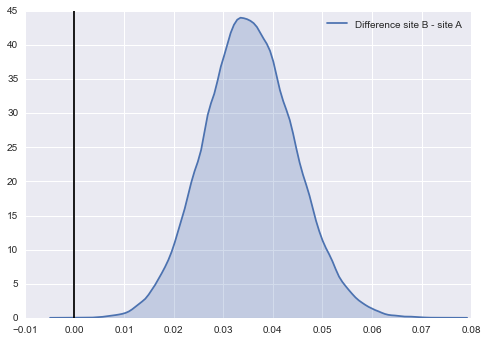

In [27]:
diff_BA = mcmc.trace('true_rates')[:][:,1] - mcmc.trace('true_rates')[:][:,0]
sns.kdeplot(diff_CA, shade = True, label = "Difference site B - site A")
plt.axvline(0.0, color = 'black')
plt.savefig("results/hierarchial_BA.png", format = "PNG")

In [28]:
print "Probability that website A gets MORE sign-ups than website B: %0.3f" % (diff_BA < 0).mean()
print "Probability that website A gets LESS sign-ups than website B: %0.3f" % (diff_BA > 0).mean()

Probability that website A gets MORE sign-ups than website B: 0.028
Probability that website A gets LESS sign-ups than website B: 0.972


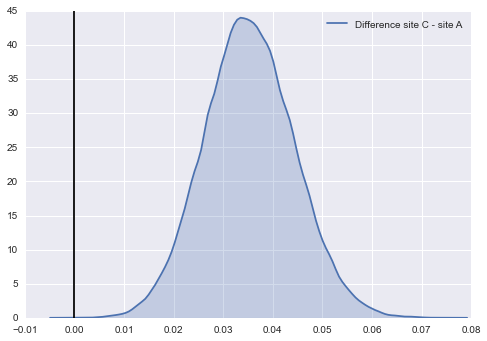

In [24]:
diff_CA = mcmc.trace('true_rates')[:][:,2] - mcmc.trace('true_rates')[:][:,0]
sns.kdeplot(diff_CA, shade = True, label = "Difference site C - site A")
plt.axvline(0.0, color = 'black')
plt.savefig("results/hierarchial_CA.png", format = "PNG")

In [25]:
print "Probability that website A gets MORE sign-ups than website C: %0.3f" % (diff_CA < 0).mean()
print "Probability that website A gets LESS sign-ups than website C: %0.3f" % (diff_CA > 0).mean()

Probability that website A gets MORE sign-ups than website C: 0.000
Probability that website A gets LESS sign-ups than website C: 1.000


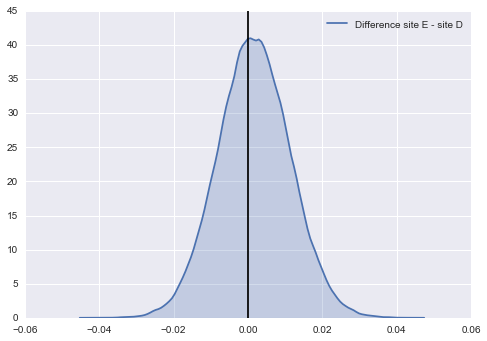

In [17]:
diff_ED = mcmc.trace('true_rates')[:][:,4] - mcmc.trace('true_rates')[:][:,3]
sns.kdeplot(diff_CA, shade = True, label = "Difference site E - site D")
plt.axvline(0.0, color = 'black')
plt.savefig("results/hierarchial_ED.png", format = "PNG")

In [30]:
print "Probability that website D gets MORE sign-ups than website E: %0.3f" % (diff_ED < 0).mean()
print "Probability that website D gets LESS sign-ups than website E: %0.3f" % (diff_ED > 0).mean()

Probability that website D gets MORE sign-ups than website E: 0.437
Probability that website D gets LESS sign-ups than website E: 0.563


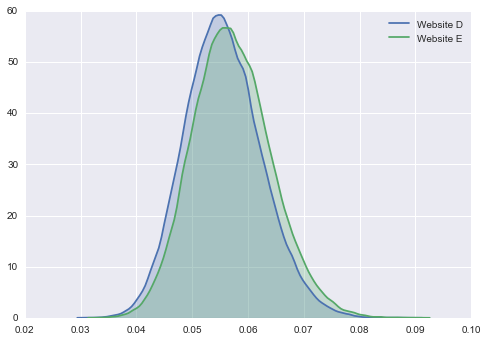

In [29]:
for i in range(3,5):
    sns.kdeplot(mcmc.trace('true_rates')[:][:,i], shade = True, label = "Website %s" % chr(65+i))
plt.savefig("results/ED_dist.png", format = "PNG")

#Comparing the two methods

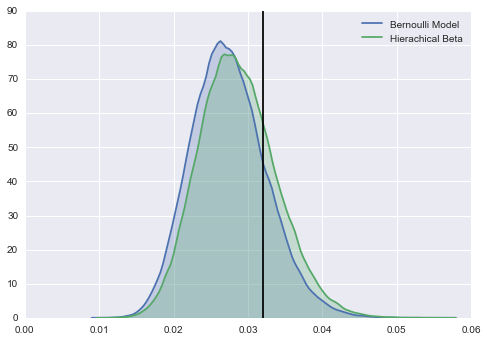

In [20]:
sns.kdeplot(siteA_distribution, shade = True, label = "Bernoulli Model")
sns.kdeplot(mcmc.trace('true_rates')[:][:,0], shade = True, label = "Hierachical Beta")
plt.axvline(0.032, color = 'black')
plt.savefig("results/hierarchial_better.png", format = "PNG")